# Testing Adaptation

In [1]:
import sys
sys.path.append("")

import os, shutil
import os.path as osp
import pickle
import json
import numpy as np
import click
import torch

import pyglet
from tensorboardX import SummaryWriter
import datetime

from envs.metaENV import ENV, VisualiserWrapper
from envs.MetaPeg2D import WINDOW_X, WINDOW_Y, ORIGIN, PEG_DEPTH
from backend.torch.PEARL.policies import TanhGaussianPolicy
from backend.torch.networks import FlattenMlp, MlpEncoder, RecurrentEncoder, LatentGNNEncoder, NormalAux
from backend.torch.PEARL.agent import PEARLAgent

from experiment import deep_update_dict
from backend.torch.PEARL.policies import MakeDeterministic
from backend.samplers.util import rollout, rollout_window
from configs.default import default_config

def run_sim_path(task_idx, trial, path, framework = 'PEARL'):
    env = VisualiserWrapper(WINDOW_X, WINDOW_Y, "RoboPeg2D Simulation", vsync = False, 
                            resizable = False, visible = False)
    env.show = False
    env.reset_task(task_idx)
    env.set_task_idx(task_idx)
    print(f'Adapting to task {task_idx} on trial {trial}')
    env.run_path(path)
    print('DONE ... \n')
    
def sim_policy(variant, 
               path_to_exp, 
               num_trajs=1, 
               deterministic=False, 
               sparse_rewards = False, 
               view=False, 
               continuous = False,
               visible = False
              ):
    '''
    simulate a trained policy adapting to a new task
    optionally save videos of the trajectories - requires ffmpeg
    :variant: experiment configuration dict
    :path_to_exp: path to exp folder
    :num_trajs: number of trajectories to simulate per task (default 1)
    :deterministic: if the policy is deterministic (default stochastic)
    :save_video: whether to generate and save a video (default False)
    '''

    env = ENV() if not view else VisualiserWrapper(WINDOW_X, WINDOW_Y, "RoboPeg2D Simulation", 
                                                   vsync = False, resizable = False, visible = visible)
    env.show = view
    tasks = env.get_all_task_idx()
    obs_dim = int(np.prod(env.observation_space.shape))
    action_dim = int(np.prod(env.action_space.shape))
    reward_dim = 1    

    eval_tasks=list(tasks[-variant['n_eval_tasks']:])
    print('testing on {} test tasks, {} trajectories each'.format(len(eval_tasks), num_trajs))

    # instantiate networks
    latent_dim = variant['latent_size']
    context_encoder_input_dim = 2 * obs_dim + action_dim + reward_dim if variant['algo_params']['use_next_obs_in_context'] else obs_dim + action_dim + reward_dim
    context_encoder_output_dim = latent_dim * 2 if variant['algo_params']['use_information_bottleneck'] else latent_dim    
    net_size = variant['net_size']
    recurrent = variant['algo_params']['recurrent']
    encoder_model = RecurrentEncoder if recurrent else MlpEncoder

    if not variant['GNN_encoder']:
        context_encoder = encoder_model(
            hidden_sizes=[128, 128, 128], 
            input_size=context_encoder_input_dim,
            output_size=context_encoder_output_dim,
        )
    else:
        context_encoder = LatentGNNEncoder(
                        input_dim= context_encoder_input_dim,
                        output_size = context_encoder_output_dim,
                        **variant['LatentGNN']
        )
    if variant['aux_loss']:
        aux_decoder = NormalAux(
            hidden_sizes = variant['aux_params']['hidden'],
            input_size = latent_dim,
            output_size = variant['aux_params']['belief_dim'],
            std = variant['aux_params']['aux_std']
        )
    policy = TanhGaussianPolicy(
        hidden_sizes=[net_size, net_size, net_size],
        obs_dim=obs_dim + latent_dim,
        latent_dim=latent_dim,
        action_dim=action_dim,
    )
    agent = PEARLAgent(
        policy,
        context_encoder=context_encoder,
        aux_decoder=aux_decoder,
        aux_params = variant['aux_params'],
        latent_dim=latent_dim,
        **variant['algo_params']
    )
    
    # deterministic eval
    if deterministic:
        agent = MakeDeterministic(agent)

    # load trained weights (otherwise simulate random policy)
    context_encoder.load_state_dict(torch.load(os.path.join(path_to_exp, 'context_encoder.pth')))
    policy.load_state_dict(torch.load(os.path.join(path_to_exp, 'policy.pth')))
    if aux_decoder is not None:
        aux_decoder.load_state_dict(torch.load(os.path.join(path_to_exp, 'aux_decoder.pth')))

    if view:
        env.set_visible(visible = visible)
        env.set_visibles()
        
    max_steps = 200
    context_window_length = 20
    
    # loop through tasks collecting rollouts
    all_rets = []
    all_paths = []
    for idx in eval_tasks:
        env.set_task_idx(idx)
        env.reset_task(idx)
        env.rollout_counter = 0
        agent.clear_z()
        paths = []
        if not continuous:
            for n in range(num_trajs):
                if view:
                    print(f'Adapting to task {idx} on trial {n}')
                    env.view_rollout(agent, accum_context = True, max_steps = variant['algo_params']['max_path_length'],
                                    sparse_rewards = sparse_rewards)
                    env.reset_task(idx)
                else:
                    path = rollout(env, agent, max_path_length=variant['algo_params']['max_path_length'], 
                                   accum_context=True, sparse_rewards = sparse_rewards)
                    if n >= variant['algo_params']['num_exp_traj_eval']:
                        agent.infer_posterior(agent.context)
                    paths.append(path)
            env.all_paths.append(env.trajectories)
        else:
            if view:
                env.view_rollout(agent, accum_context = True, max_steps = max_steps, 
                                 continuous_update = continuous, sparse_rewards = sparse_rewards)#,
#                                 context_window_length = variant['algo_params']['context_window_steps'])
                env.reset_task(idx)
                env.all_paths.append(env.trajectories)
            else:
                path = rollout_window(env, agent, max_path_length = max_steps, context_window_length = context_window_length, accum_context= True, animated = view)

        all_rets.append([sum(p['rewards']) for p in paths])
#         all_paths.append(paths)

#         if view:
#             for n in range(num_trajs):
#                 run_sim_path(idx, n, paths[n])
                
    # compute average returns across tasks
    if not view:
        n = min([len(a) for a in all_rets])
        rets = [a[:n] for a in all_rets]
        rets = np.mean(np.stack(rets), axis=0)
        for i, ret in enumerate(rets):
            print('trajectory {}, avg return: {} \n'.format(i, ret))

    return env.all_paths 

def main(config, path, num_trajs = 5, deterministic = False, sparse_rewards = False, 
         view = False, continuous = False, visible = False):
    variant = default_config
    if config:
        with open(osp.join(config)) as f:
            exp_params = json.load(f)
        variant = deep_update_dict(exp_params, variant)
    variant['util_params']['use_gpu']
    return sim_policy(variant, path, num_trajs, deterministic, sparse_rewards, view, continuous, visible = visible)

if __name__ == "__main__":
    config = None
    num_trajs = 4
    path = "output/Peg2D/2020_07_20_17_56_19"
    # 2020_07_08_15_51_03
#     all_paths_traj_sparse = main(config, path, num_trajs, 
#                      deterministic = False, 
#                      sparse_rewards = True, 
#                      view = True, 
#                      continuous= False,
#                      visible = True)
    
    all_paths_cont_sparse = main(config, path, num_trajs, 
                 deterministic = False, 
                 sparse_rewards = True, 
                 view = True, 
                 continuous= True,
                 visible = True)
    
#     all_paths_cont = main(config, path, num_trajs, 
#                  deterministic = False, 
#                  sparse_rewards = False, 
#                  view = True, 
#                  continuous= True,
#                  visible = False)

Loading chipmunk for Windows (64bit) [C:\Users\Alvaro\Anaconda3\lib\site-packages\pymunk\chipmunk.dll]
testing on 10 test tasks, 4 trajectories each


C:\Users\Alvaro\Anaconda3\lib\site-packages\torch\cuda\__init__.py:135: UserWarning: 
    Found GPU0 GeForce GT 750M which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


Updating continuous belief at traj 0 and roll 0
Updating continuous belief at traj 20 and roll 20
Updating continuous belief at traj 40 and roll 40
Updating continuous belief at traj 60 and roll 60
Updating continuous belief at traj 80 and roll 80
Updating continuous belief at traj 100 and roll 100
Updating continuous belief at traj 120 and roll 120
Updating continuous belief at traj 140 and roll 140
Updating continuous belief at traj 160 and roll 160
Updating continuous belief at traj 180 and roll 180
Ending Task ... 

Updating continuous belief at traj 0 and roll 0
Updating continuous belief at traj 20 and roll 20
Updating continuous belief at traj 40 and roll 40
Updating continuous belief at traj 60 and roll 60
Updating continuous belief at traj 80 and roll 80
Updating continuous belief at traj 100 and roll 100
Updating continuous belief at traj 120 and roll 120
Updating continuous belief at traj 140 and roll 140
Updating continuous belief at traj 160 and roll 160
Updating continuou

# Evaluation

In [4]:
from eval_utils import *
import seaborn as sns
import matplotlib.pyplot as plt
from envs.MetaPeg2D import norm_pos, denorm_pos

In [48]:
[len(all_paths_traj[x]) for x in range(len(all_paths_traj))]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4]

In [75]:
[len(all_paths_traj_sparse[x]) for x in range(len(all_paths_traj_sparse))]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4]

In [76]:
[[x['rollout_length'] for x in all_paths_traj[y]] for y in range(len(all_paths_traj))]

[[50, 50, 50, 50],
 [50, 50, 50, 50],
 [50, 50, 50, 50],
 [50, 50, 41, 50],
 [50, 50, 50, 50],
 [50, 50, 50, 50],
 [50, 50, 50, 50],
 [50, 50, 50, 50],
 [50, 50, 50, 50],
 [34, 35, 47, 50]]

In [77]:
[[x['rollout_length'] for x in all_paths_traj_sparse[y]] for y in range(len(all_paths_traj_sparse))]

[[50, 50, 50, 50],
 [50, 50, 50, 50],
 [50, 50, 50, 50],
 [50, 50, 50, 50],
 [50, 50, 50, 50],
 [50, 50, 50, 50],
 [50, 50, 50, 50],
 [50, 50, 50, 50],
 [50, 50, 50, 50],
 [50, 50, 50, 50]]

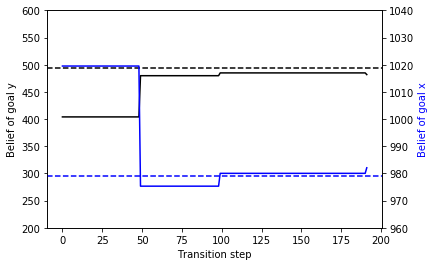

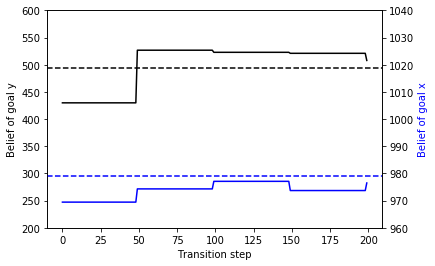

In [50]:
belief_plot(all_paths_traj[3])
plt.figure()
belief_plot(all_paths_traj_sparse[3])

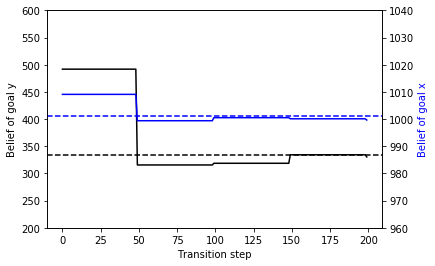

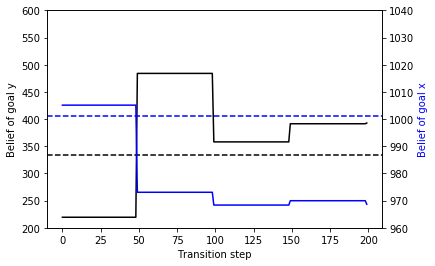

In [51]:
belief_plot(all_paths_traj[6])
plt.figure()
belief_plot(all_paths_traj_sparse[6])

In [78]:
[len(all_paths_cont[x]) for x in range(len(all_paths_cont))]

[1, 1, 1, 2, 1, 3, 1, 1, 1, 5]

In [2]:
[len(all_paths_cont_sparse[x]) for x in range(len(all_paths_cont_sparse))]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [67]:
[[x['rollout_length'] for x in all_paths_cont[y]] for y in range(len(all_paths_cont))]

[[200],
 [200],
 [200],
 [57, 143],
 [200],
 [200],
 [200],
 [200],
 [143, 57],
 [48, 152]]

In [82]:
[[x['rollout_length'] for x in all_paths_cont_sparse[y]] for y in range(len(all_paths_cont_sparse))]

[[200], [200], [200], [200], [200], [200], [200], [200], [200], [200]]

In [3]:
belief_plot(all_paths_cont[9])
plt.figure()
belief_plot(all_paths_cont_sparse[9])

NameError: name 'belief_plot' is not defined

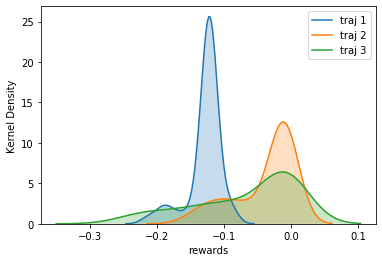

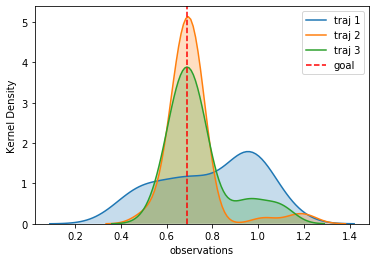

In [86]:
traj_histo(all_paths_traj[1][:3], param = 'rewards')
plt.figure()
traj_histo(all_paths_traj[1][:3], param = 'observations', var_idx=1)

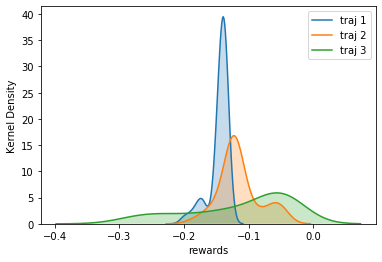

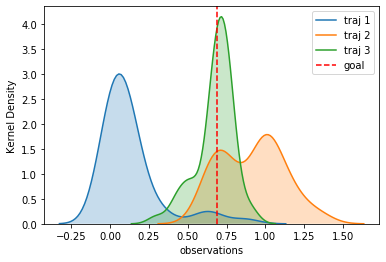

In [87]:
traj_histo(all_paths_traj_sparse[1][:3], param = 'rewards')
plt.figure()
traj_histo(all_paths_traj_sparse[1][:3], param = 'observations', var_idx=1)

In [76]:
traj_histo(all_paths_cont[3], param = 'rewards')
plt.figure()
traj_histo(all_paths_cont[3], param = 'observations', var_idx=1)

NameError: name 'sns' is not defined

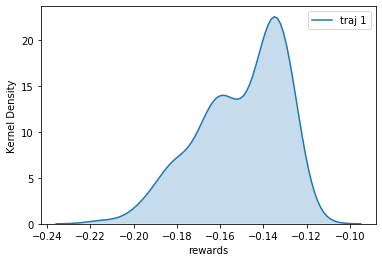

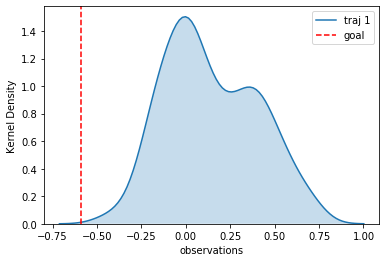

In [5]:
traj_histo(all_paths_cont_sparse[2], param = 'rewards')
plt.figure()
traj_histo(all_paths_cont_sparse[2], param = 'observations', var_idx=1)

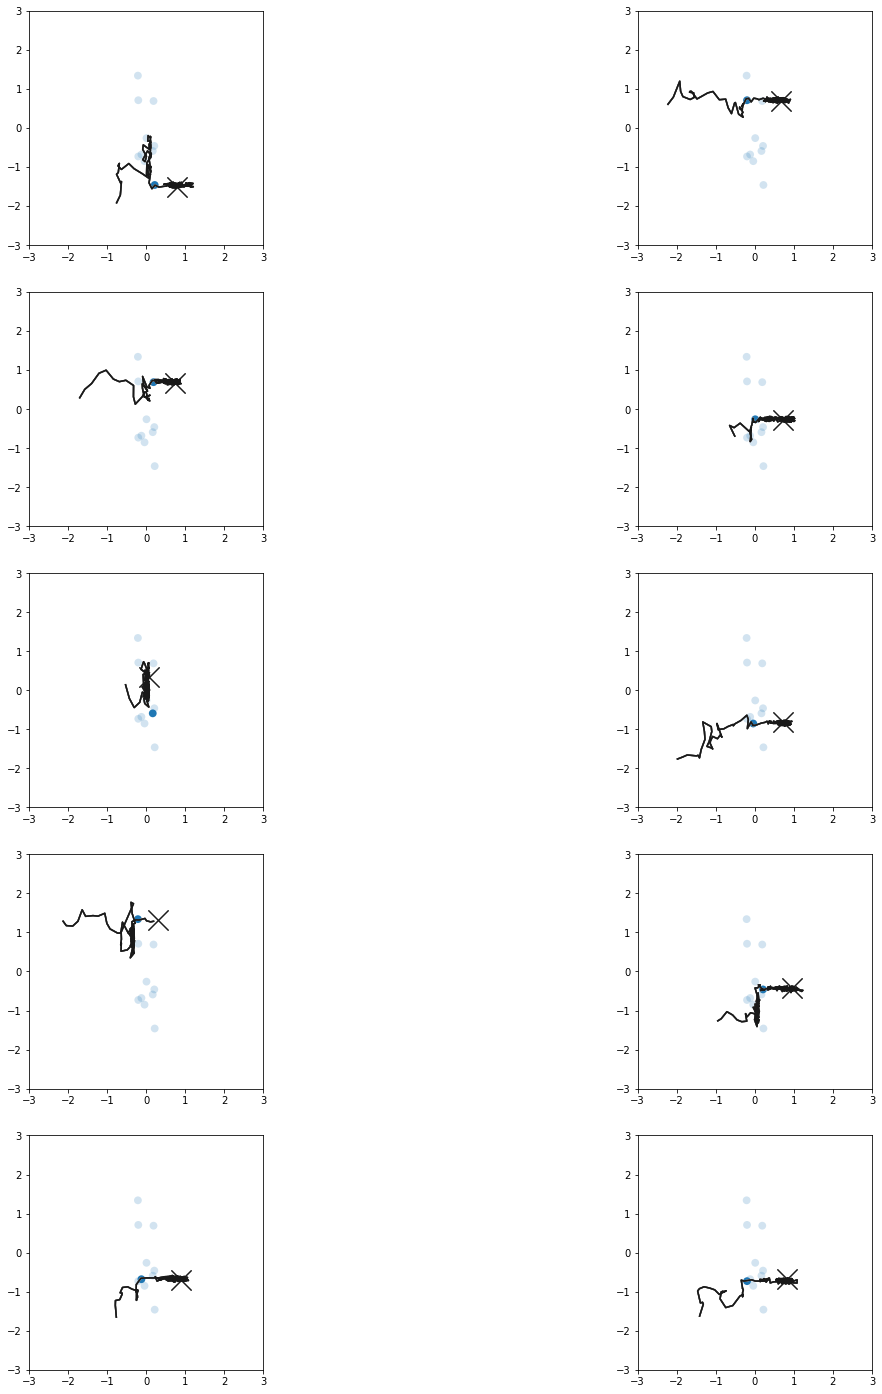

In [6]:
plot_trajectories(all_paths = all_paths_cont_sparse, num_trajs = 6)

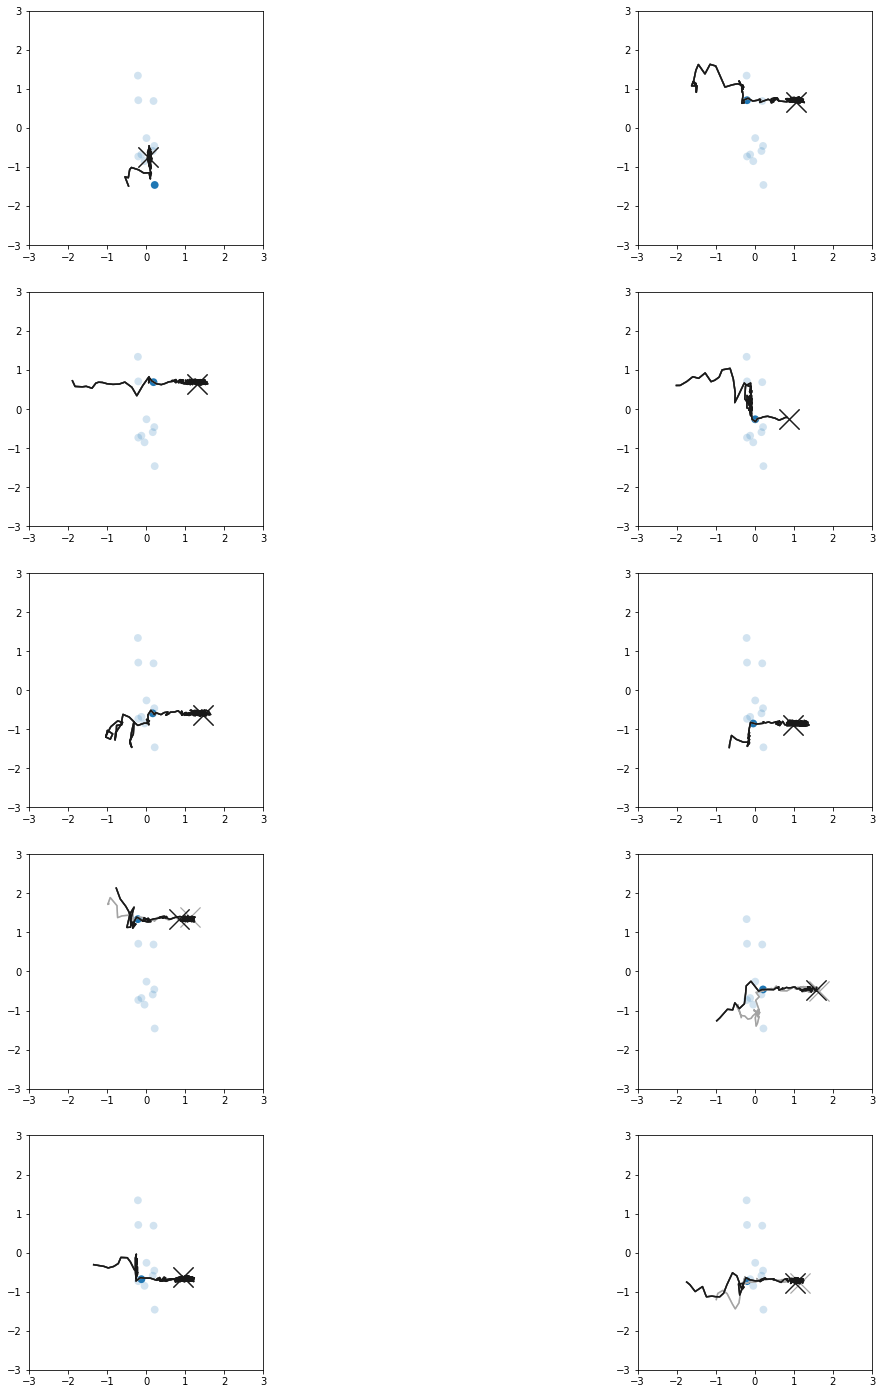

In [77]:
plot_trajectories(all_paths = all_paths_cont, num_trajs = 6)

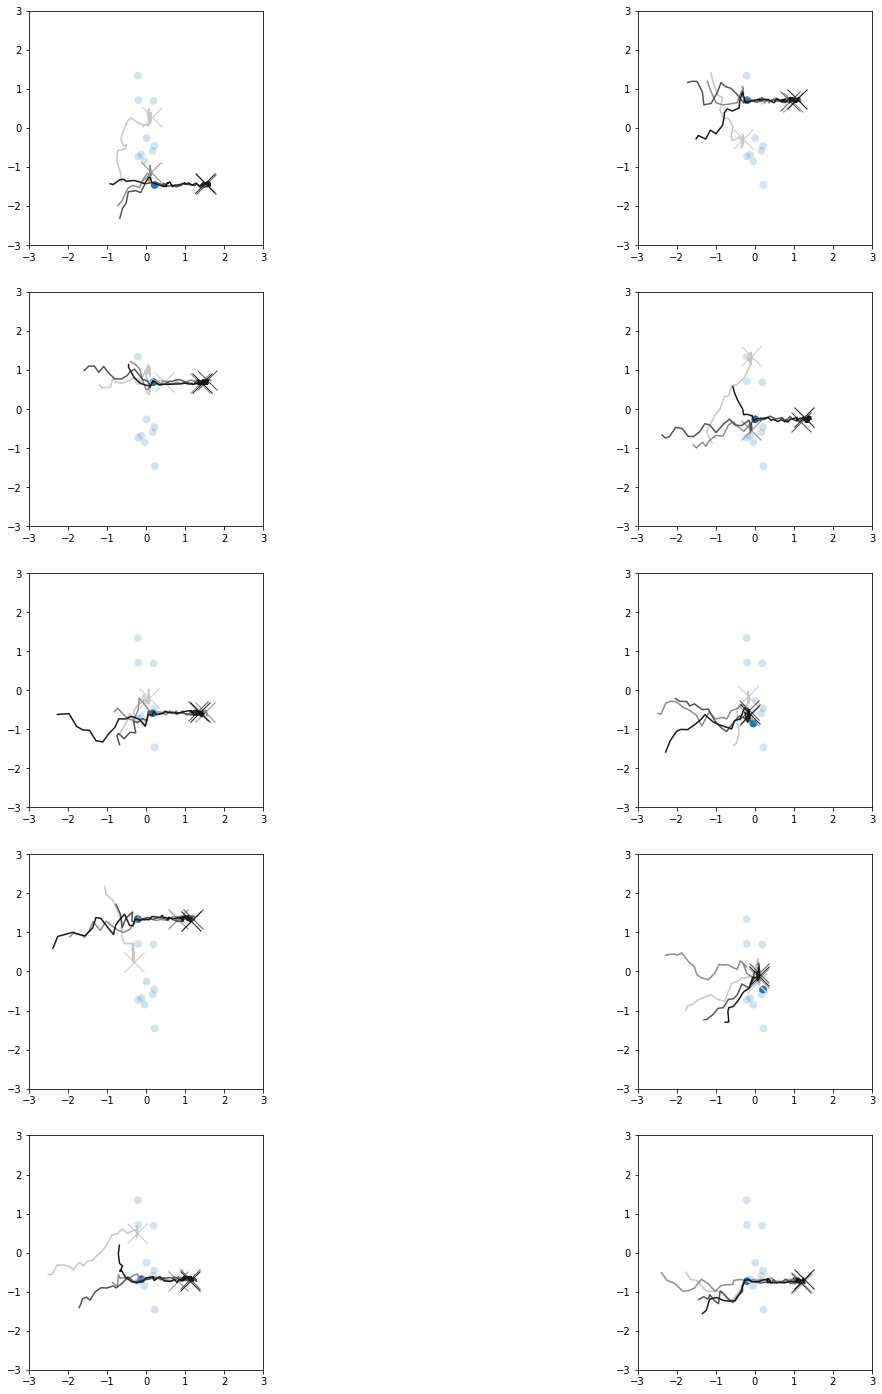

In [92]:
plot_trajectories(all_paths = all_paths_traj, num_trajs = 5)

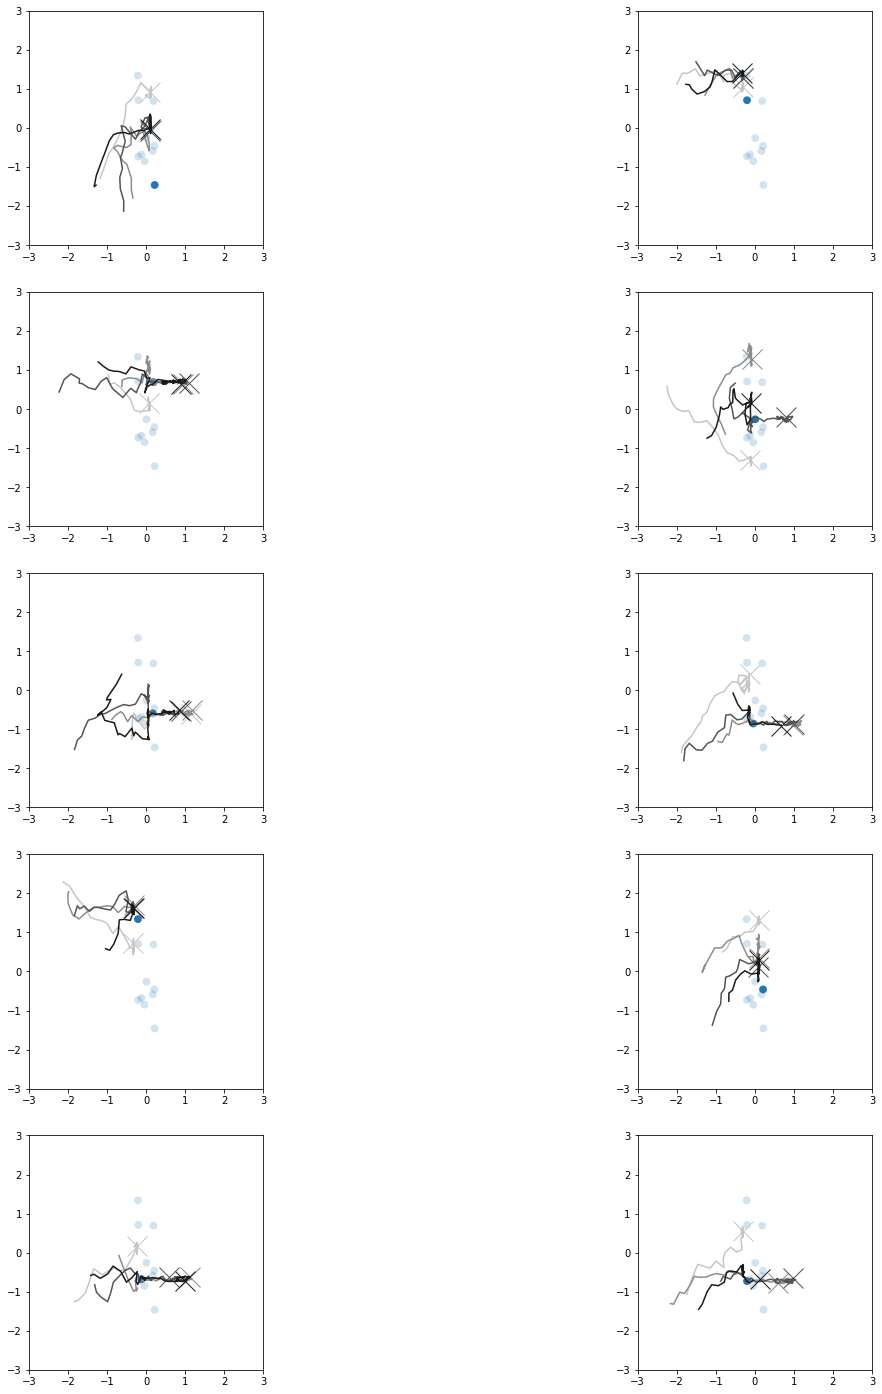

In [104]:
plot_trajectories(all_paths = all_paths_traj_sparse, num_trajs = 5)

## Task finder

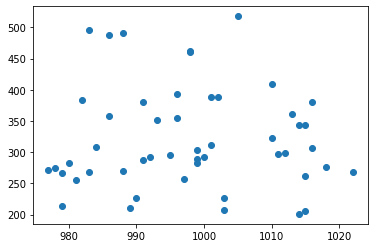

In [62]:
import numpy as np
listt = []
goal_x = np.random.randint(975, 1025,50)
goal_y = np.random.randint(200, 520, 50)
zip(goal_x, goal_y)
for x,y in zip(goal_x, goal_y):
    listt.append(Vec2d(x,y))
import matplotlib.pyplot as plt
plt.figure()
plt.scatter([x[0] for x in listt], [x[1] for x in listt])
plt.show()

In [63]:
listt

[Vec2d(1018, 276),
 Vec2d(995, 295),
 Vec2d(986, 358),
 Vec2d(1015, 344),
 Vec2d(982, 383),
 Vec2d(1005, 518),
 Vec2d(980, 283),
 Vec2d(991, 380),
 Vec2d(999, 303),
 Vec2d(999, 289),
 Vec2d(1014, 344),
 Vec2d(978, 274),
 Vec2d(999, 283),
 Vec2d(991, 287),
 Vec2d(993, 352),
 Vec2d(1002, 389),
 Vec2d(986, 488),
 Vec2d(989, 210),
 Vec2d(1015, 206),
 Vec2d(1000, 292),
 Vec2d(979, 267),
 Vec2d(998, 463),
 Vec2d(1013, 362),
 Vec2d(996, 393),
 Vec2d(979, 214),
 Vec2d(1011, 297),
 Vec2d(988, 491),
 Vec2d(998, 461),
 Vec2d(1016, 307),
 Vec2d(992, 293),
 Vec2d(1003, 227),
 Vec2d(1003, 208),
 Vec2d(1010, 322),
 Vec2d(1001, 311),
 Vec2d(977, 272),
 Vec2d(988, 270),
 Vec2d(997, 257),
 Vec2d(1022, 268),
 Vec2d(984, 309),
 Vec2d(983, 496),
 Vec2d(1014, 201),
 Vec2d(1015, 261),
 Vec2d(996, 355),
 Vec2d(990, 226),
 Vec2d(983, 269),
 Vec2d(981, 255),
 Vec2d(1012, 298),
 Vec2d(1010, 409),
 Vec2d(1001, 389),
 Vec2d(1016, 381)]

## Testing Demo Adaptation

In [1]:
import sys
sys.path.append("")

import os, shutil
import os.path as osp
import pickle
import json
import numpy as np
import click
import torch

import pyglet
from tensorboardX import SummaryWriter
import datetime

from envs.metaENV import ENV, VisualiserWrapper
from envs.MetaPeg2D import WINDOW_X, WINDOW_Y, ORIGIN, PEG_DEPTH
from backend.torch.PEARL.policies import TanhGaussianPolicy
from backend.torch.networks import FlattenMlp, MlpEncoder, RecurrentEncoder, LatentGNNEncoder, NormalAux
from backend.torch.PEARL.agent import PEARLAgent
from backend.torch.PEARL.sac import PEARLSoftActorCritic

from experiment import deep_update_dict
from backend.torch.PEARL.policies import MakeDeterministic
from backend.samplers.util import rollout, rollout_window
from configs.default import default_config

def run_sim_path(task_idx, trial, path, framework = 'PEARL'):
    env = VisualiserWrapper(WINDOW_X, WINDOW_Y, "RoboPeg2D Simulation", vsync = False, 
                            resizable = False, visible = False)
    env.show = False
    env.reset_task(task_idx)
    env.set_task_idx(task_idx)
    print(f'Adapting to task {task_idx} on trial {trial}')
    env.run_path(path)
    print('DONE ... \n')
    
def demo_sim_policy(variant, 
               path_to_exp, 
               num_trajs=1,
               demos = None,
               deterministic=False,  
               visible = False,
               continuous = False,
               randomise_task = False,
              ):
    '''
    simulate a trained policy adapting to a new task
    optionally save videos of the trajectories - requires ffmpeg
    :variant: experiment configuration dict
    :path_to_exp: path to exp folder
    :num_trajs: number of trajectories to simulate per task (default 1)
    :deterministic: if the policy is deterministic (default stochastic)
    :save_video: whether to generate and save a video (default False)
    '''
    view = True

    env = ENV() if not view else VisualiserWrapper(WINDOW_X, WINDOW_Y, "RoboPeg2D Simulation", 
                                                   vsync = False, resizable = False, visible = visible)
    env.show = view
    tasks = env.get_all_task_idx()
    obs_dim = int(np.prod(env.observation_space.shape))
    action_dim = int(np.prod(env.action_space.shape))
    reward_dim = 1    

    eval_tasks=list(tasks[-variant['n_eval_tasks']:])
    print('testing on {} test tasks, {} trajectories each'.format(len(eval_tasks), num_trajs))

    # instantiate networks
    latent_dim = variant['latent_size']
    context_encoder_input_dim = 2 * obs_dim + action_dim + reward_dim if variant['algo_params']['use_next_obs_in_context'] else obs_dim + action_dim + reward_dim
    context_encoder_output_dim = latent_dim * 2 if variant['algo_params']['use_information_bottleneck'] else latent_dim    
    net_size = variant['net_size']

    context_encoder = LatentGNNEncoder(
                    input_dim= context_encoder_input_dim,
                    output_size = context_encoder_output_dim,
                    **variant['LatentGNN']
    )
    if variant['aux_loss']:
        aux_decoder = NormalAux(
            hidden_sizes = variant['aux_params']['hidden'],
            input_size = latent_dim,
            output_size = variant['aux_params']['belief_dim'],
            std = variant['aux_params']['aux_std']
        )
    qf1 = FlattenMlp(
        hidden_sizes=[net_size, net_size, net_size],
        input_size=obs_dim + action_dim + latent_dim,
        output_size=1,
    )
    qf2 = FlattenMlp(
        hidden_sizes=[net_size, net_size, net_size],
        input_size=obs_dim + action_dim + latent_dim,
        output_size=1,
    )
    vf = FlattenMlp(
        hidden_sizes=[net_size, net_size, net_size],
        input_size=obs_dim + latent_dim,
        output_size=1,
    )
    policy = TanhGaussianPolicy(
        hidden_sizes=[net_size, net_size, net_size],
        obs_dim=obs_dim + latent_dim,
        latent_dim=latent_dim,
        action_dim=action_dim,
    )
    agent = PEARLAgent(
        policy,
        context_encoder=context_encoder,
        aux_decoder=aux_decoder,
        aux_params = variant['aux_params'],
        latent_dim=latent_dim,
        **variant['algo_params']
    )

    # load trained weights (otherwise simulate random policy)
    context_encoder.load_state_dict(torch.load(os.path.join(path_to_exp, 'context_encoder.pth'), map_location='cpu'))
    policy.load_state_dict(torch.load(os.path.join(path_to_exp, 'policy.pth'),map_location='cpu'))
    if aux_decoder is not None:
        aux_decoder.load_state_dict(torch.load(os.path.join(path_to_exp, 'aux_decoder.pth'),map_location='cpu'))

    nets = [agent, qf1, qf2, vf] 
    nets.append(context_encoder)
    if aux_decoder is not None:
        nets.append(aux_decoder)
    algorithm = PEARLSoftActorCritic(
        env=env,
        train_tasks=list(tasks[:variant['n_train_tasks']]),
        eval_tasks=list(tasks[-variant['n_eval_tasks']:]),
        nets=nets,
        demo_paths=demos,
        decoupled = variant['decoupled_config']['use'],
        **variant['algo_params']
    )
    algorithm.load_demos()   
    
    env.set_visible(visible = visible)
    env.set_visibles()
        
    max_steps = 300
    
    # loop through tasks collecting rollouts
    all_rets = []
    accum_trajs = True
    use_demos = True
    
    all_paths = []
    for idx in eval_tasks:
        env.set_task_idx(idx)
        env.reset_task(idx)
        if randomise_task:
            env.alter_task()
        env.rollout_counter = 0
        demo_context = algorithm.sample_context(idx, demos = True, batch_size = 64, entire_traj = False)
        if use_demos:
            agent.demo_clear_z(demo_context)
        else:
            agent.clear_z()
        paths = []
        det = False
        
        if continuous:
            print(f'Adapting to task {idx} on continuous adaptation, extended context True')
            env.view_rollout(agent, accum_context = accum_trajs, max_steps = max_steps, 
                             continuous_update = True, sparse_rewards = True,
                            deterministic = deterministic)
            env.reset_task(idx)
            env.all_paths.append(env.trajectories)
        else:
            for n in range(num_trajs):
                print(f'Adapting to task {idx} on trial {n}, extended context {accum_trajs}')
                env.view_rollout(agent,
                                accum_context = accum_trajs,
                                max_steps = variant['algo_params']['max_path_length'],
                                sparse_rewards = True,
                                deterministic = det)
                env.reset_task(idx)
                if n >= variant['algo_params']['num_exp_traj_eval'] and deterministic:
                    _suc = [x['terminals'][-1] for x in env.trajectories[-variant['algo_params']['num_exp_traj_eval']:]]
                    if sum(_suc) == variant['algo_params']['num_exp_traj_eval']:
                        det = True
                        accum_trajs = False
                        print("Acting Deterministic")
                    else:
                        det = False
                        accum_trajs = True
                        print("Not acting deterministic because we haven't explored enough")
            env.all_paths.append(env.trajectories)
        
        all_rets.append([sum(p['rewards']) for p in paths])

    return env.all_paths 

def main(config, path, num_trajs = 5, demos = None, deterministic = False, 
         continuous = False, visible = False, randomise_task = False):
    variant = default_config
    if config:
        with open(osp.join(config)) as f:
            exp_params = json.load(f)
        variant = deep_update_dict(exp_params, variant)
    return demo_sim_policy(variant, path, num_trajs, demos, deterministic, visible, continuous, randomise_task)

if __name__ == "__main__":
    config = None
    num_trajs = 10
    demos_path = "expert/Peg2D/ExpertPeg2DPaths"
    with open(demos_path + '.pickle', 'rb') as handle:
        demos = pickle.load(handle)
#     path = "output/Peg2D/2020_08_08_13_42_38" # Works well down to 2.5 reward average. Not that good at interpreting on-policy transitions
#     all_paths_traj_sparse_over = main(config, path, num_trajs, 
#                      demos = demos,
#                      deterministic = True, 
#                      continuous = False,
#                      visible = True,
#                      randomise_task = True)
    # path = "output/Peg2D/2020_08_08_18_26_12" # Works well down to 4 reward average. Really good at compromising Linfo via mixed auxilliary losses (demo, xplor)
#     path = "output/Peg2D/2020_08_10_12_54_13" # improved meta-test adaptation via encoder context training only
#     all_paths_traj_sparse_xplor = main(config, path, num_trajs, 
#                      demos = demos,
#                      deterministic = True, 
#                      continuous = False,
#                      visible = True,
#                      randomise_task = False)
    path = "output/Peg2D/2020_08_11_17_44_16" # We did it! This is the BEST. Adapts to imperfect demonstrations. 
    all_paths_traj_sparse_imperfect = main(config, path, num_trajs, 
                     demos = demos,
                     deterministic = True, 
                     continuous = False,
                     visible = True,
                     randomise_task = True)

Loading chipmunk for Windows (64bit) [C:\Users\Alvaro\Anaconda3\lib\site-packages\pymunk\chipmunk.dll]
Not using experts, in for meta-training... 



C:\Users\Alvaro\Anaconda3\lib\site-packages\pyglet\image\codecs\wic.py:292: UserWarning: [WinError -2147417850] No se puede cambiar el modo de subproceso después de establecerlo
  warnings.warn(str(err))


testing on 10 test tasks, 10 trajectories each
Operating demonstrations from dict_keys(['Peg2D']) 

Acting on mutual information: False
Operating on a single task family: Peg2D
Adapting to task 40 on trial 0, extended context True
Speeding out DT by factor 5
torch.Size([1, 96, 12]) torch.Size([1, 256, 12])
Updating trajctory belief at traj 31 and roll 31
Ending Task ... 

Adapting to task 40 on trial 1, extended context True
Speeding out DT by factor 5
torch.Size([1, 134, 12]) torch.Size([1, 256, 12])
Updating trajctory belief at traj 37 and roll 69
Ending Task ... 

Adapting to task 40 on trial 2, extended context True
Speeding out DT by factor 5
torch.Size([1, 162, 12]) torch.Size([1, 256, 12])
Updating trajctory belief at traj 27 and roll 97
Ending Task ... 

Adapting to task 40 on trial 3, extended context True
Speeding out DT by factor 5
torch.Size([1, 190, 12]) torch.Size([1, 256, 12])
Updating trajctory belief at traj 27 and roll 125
Ending Task ... 

Acting Deterministic
Adapti

torch.Size([1, 64, 12]) torch.Size([1, 256, 12])
Updating trajctory belief at traj 18 and roll 197
Ending Task ... 

Acting Deterministic
Adapting to task 43 on trial 8, extended context False
Speeding out DT by factor 5
torch.Size([1, 64, 12]) torch.Size([1, 256, 12])
Updating trajctory belief at traj 18 and roll 216
Ending Task ... 

Acting Deterministic
Adapting to task 43 on trial 9, extended context False
Speeding out DT by factor 5
torch.Size([1, 64, 12]) torch.Size([1, 256, 12])
Updating trajctory belief at traj 19 and roll 236
Ending Task ... 

Acting Deterministic
Adapting to task 44 on trial 0, extended context False
Speeding out DT by factor 5
torch.Size([1, 64, 12]) torch.Size([1, 256, 12])
Updating trajctory belief at traj 19 and roll 19
Ending Task ... 

Adapting to task 44 on trial 1, extended context False
Speeding out DT by factor 5
torch.Size([1, 64, 12]) torch.Size([1, 256, 12])
Updating trajctory belief at traj 19 and roll 39
Ending Task ... 

Adapting to task 44 on

torch.Size([1, 64, 12]) torch.Size([1, 256, 12])
Updating trajctory belief at traj 33 and roll 192
Ending Task ... 

Acting Deterministic
Adapting to task 47 on trial 6, extended context False
Speeding out DT by factor 5
torch.Size([1, 64, 12]) torch.Size([1, 256, 12])
Updating trajctory belief at traj 29 and roll 222
Ending Task ... 

Acting Deterministic
Adapting to task 47 on trial 7, extended context False
Speeding out DT by factor 5
torch.Size([1, 64, 12]) torch.Size([1, 256, 12])
Updating trajctory belief at traj 33 and roll 256
Ending Task ... 

Acting Deterministic
Adapting to task 47 on trial 8, extended context False
Speeding out DT by factor 5
torch.Size([1, 64, 12]) torch.Size([1, 256, 12])
Updating trajctory belief at traj 33 and roll 290
Ending Task ... 

Acting Deterministic
Adapting to task 47 on trial 9, extended context False
Speeding out DT by factor 5
torch.Size([1, 64, 12]) torch.Size([1, 256, 12])
Updating trajctory belief at traj 34 and roll 325
Ending Task ... 


In [2]:
from eval_utils import *
import seaborn as sns
import matplotlib.pyplot as plt
from envs.MetaPeg2D import norm_pos, denorm_pos

Loading chipmunk for Windows (64bit) [C:\Users\Alvaro\Anaconda3\lib\site-packages\pymunk\chipmunk.dll]


In [3]:
[[x['rollout_length'] for x in all_paths_traj_sparse_imperfect[y]] for y in range(len(all_paths_traj_sparse_imperfect))]

[[30, 22, 30, 30, 22, 22, 21, 17, 20, 19],
 [23, 50, 50, 23, 50, 27, 36, 24, 21, 19],
 [32, 37, 24, 17, 24, 15, 20, 15, 18, 25],
 [36, 16, 48, 16, 29, 21, 44, 20, 43, 29],
 [27, 22, 23, 27, 24, 34, 24, 25, 24, 28],
 [26, 24, 20, 31, 50, 44, 22, 14, 14, 21],
 [29, 23, 23, 25, 19, 17, 23, 18, 17, 29],
 [23, 26, 24, 23, 24, 21, 21, 22, 19, 18],
 [36, 35, 21, 20, 21, 46, 19, 37, 50, 35],
 [20, 21, 16, 23, 19, 43, 16, 17, 12, 15]]

In [4]:
[[x['rollout_length'] for x in all_paths_traj_sparse_xplor[y]] for y in range(len(all_paths_traj_sparse_xplor))]

[[21, 26, 22, 23, 22],
 [26, 20, 27, 34, 25],
 [19, 26, 20, 18, 19],
 [50, 30, 36, 50, 48],
 [24, 19, 26, 50, 45],
 [40, 40, 50, 50, 21],
 [30, 50, 27, 32, 42],
 [50, 50, 50, 50, 30],
 [22, 18, 24, 17, 16],
 [27, 30, 24, 30, 42]]

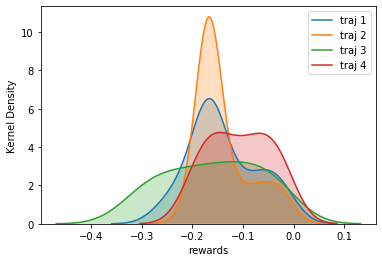

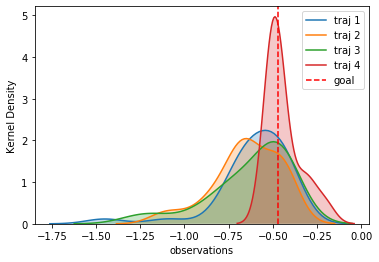

In [7]:
# traj_histo(all_paths_traj_sparse_over[2][:5], param = 'rewards')
# plt.figure()
# traj_histo(all_paths_traj_sparse_over[2][:5], param = 'observations', var_idx=1)

# plt.figure()
# traj_histo(all_paths_traj_sparse_xplor[0][1:4], param = 'rewards')
# plt.figure()
# traj_histo(all_paths_traj_sparse_xplor[0][1:4], param = 'observations', var_idx=1)

plt.figure()
traj_histo(all_paths_traj_sparse_imperfect[2][0:4], param = 'rewards')
plt.figure()
traj_histo(all_paths_traj_sparse_imperfect[2][0:4], param = 'observations', var_idx=1)

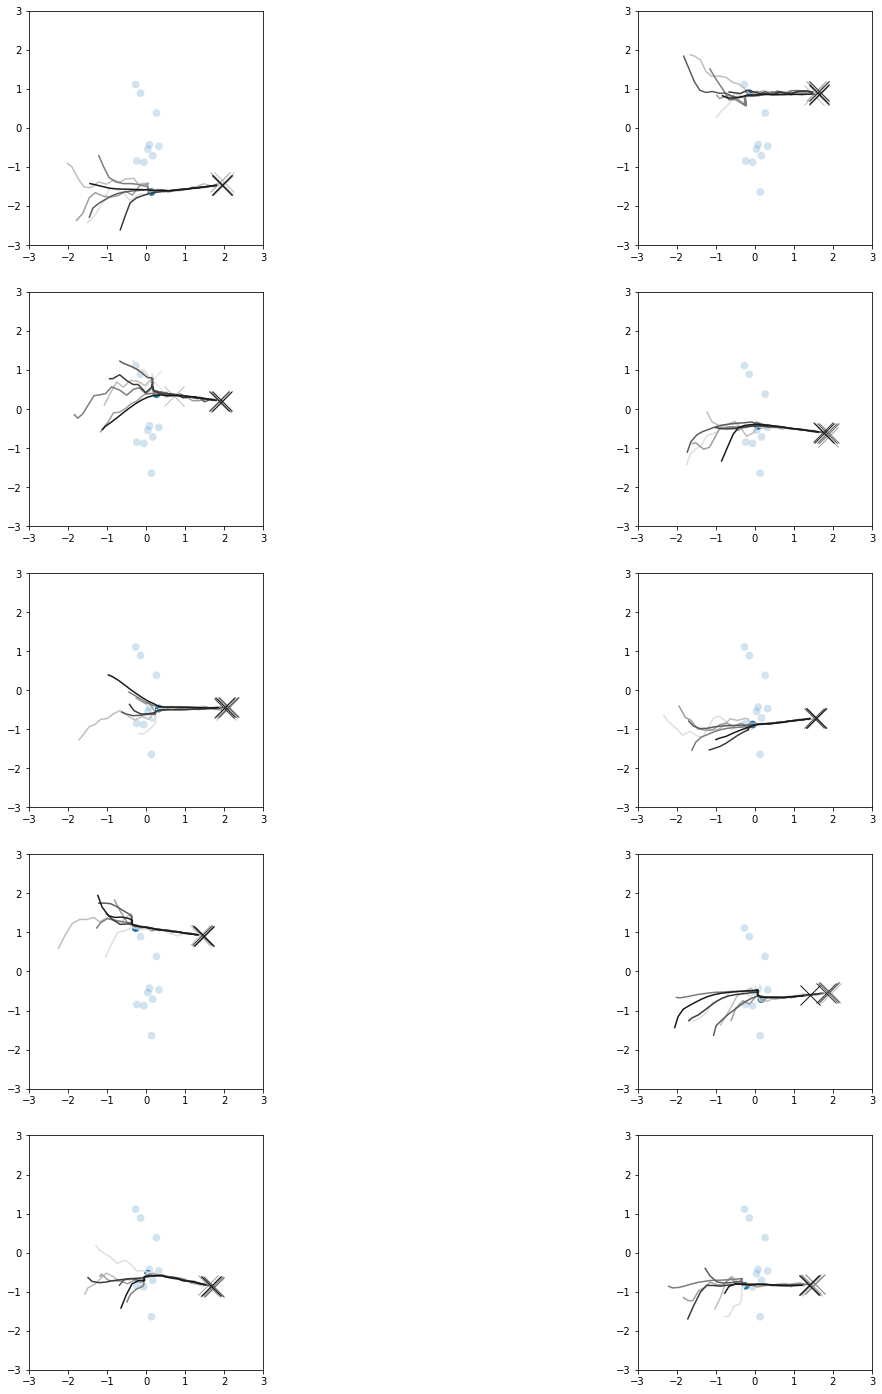

In [8]:
# plot_trajectories(all_paths = all_paths_traj_sparse_over, num_trajs = 5)
plot_trajectories(all_paths = all_paths_traj_sparse_imperfect, num_trajs = 8)

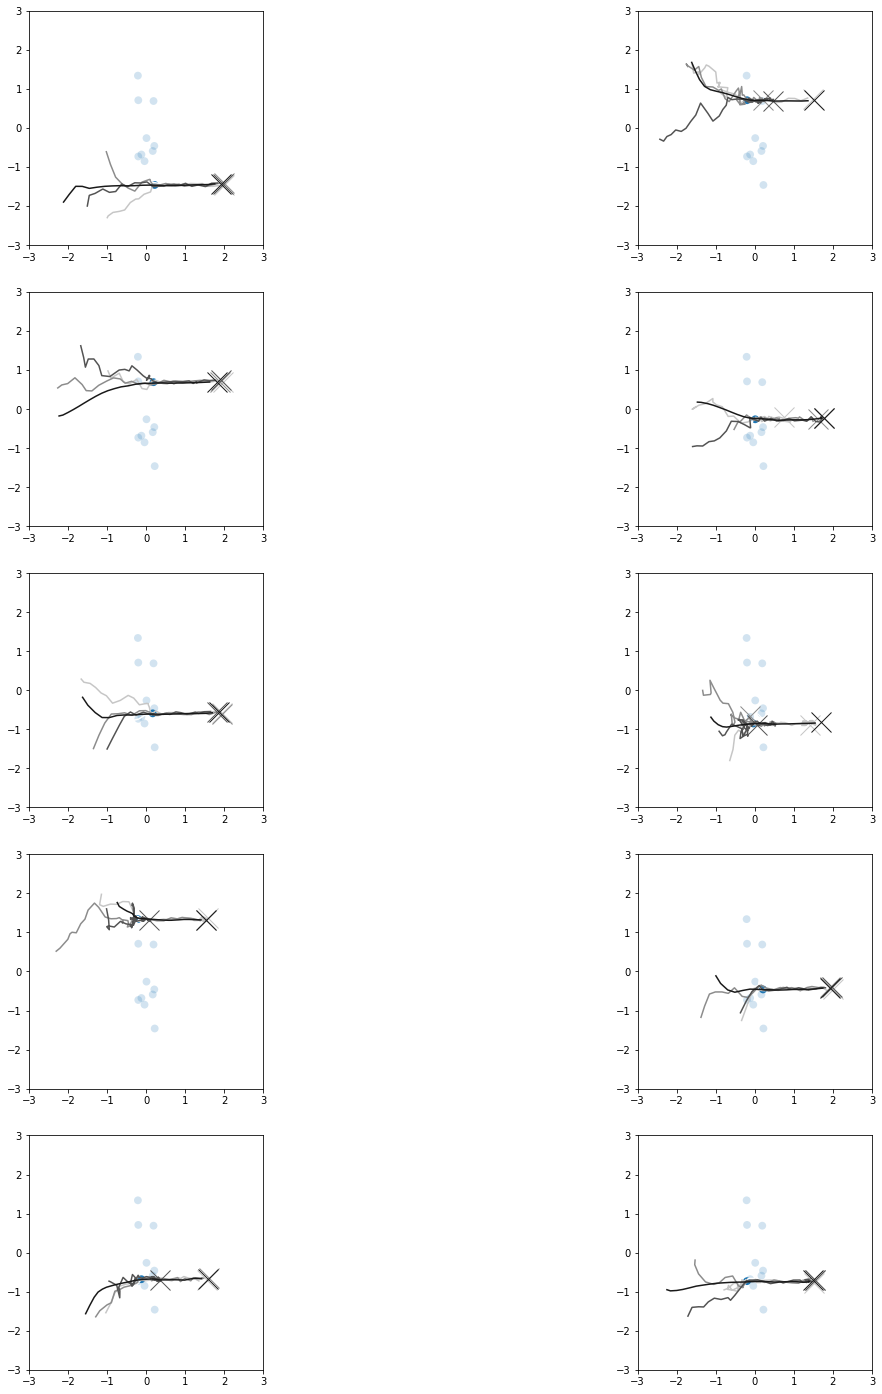

In [10]:
plot_trajectories(all_paths = all_paths_traj_sparse_xplor, num_trajs = 5)

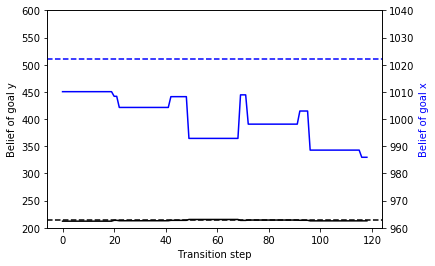

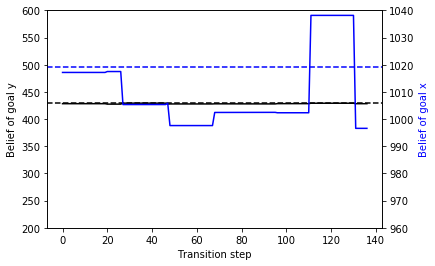

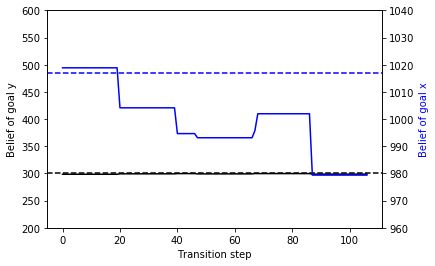

In [16]:
belief_plot(all_paths_traj_sparse_xplor[0])
plt.figure()
belief_plot(all_paths_traj_sparse_xplor[1])
plt.figure()
belief_plot(all_paths_traj_sparse_xplor[2])

In [3]:
belief_plot(all_paths_traj_sparse_imperfect[6])
plt.figure()
belief_plot(all_paths_traj_sparse_imperfect[5])
plt.figure()
belief_plot(all_paths_traj_sparse_imperfect[3])

NameError: name 'all_paths_traj_sparse_imperfect' is not defined